In [19]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

Data analyzed: 5-minute increment measurements of CO2 emissions (mTCO2/h), energy generation by resource (MW), and electricity demand (MW)\
Find: relation between demand and CO2 emissions\
Question: can we predict emissions with only demand?

**Load data**

In [9]:
# 5-minute increments of CA CO2 emissions, electricity demand, and energy generated by different sources

df = pd.read_csv('data/cleaned/minute_emissions_demand_resource.csv')
df.rename(columns={'Unnamed: 0':'time'},inplace=True)
print(f'shape: {df.shape}')
df.head()

shape: (7776, 18)


,time,date,emissions,demand,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,total generated
0,00:00,20221112,8079,22291.0,14108,1075,4101,131,1130,2,0,4,535,949,241,213,111,22600
1,00:05,20221112,7997,22389.0,14092,951,3889,643,1130,2,0,4,533,949,242,213,111,22759
2,00:10,20221112,7915,22412.0,14040,912,3715,840,1130,2,0,4,517,949,242,213,113,22677
3,00:15,20221112,7874,22358.0,14157,933,3641,826,1130,3,0,4,507,949,242,213,115,22720
4,00:20,20221112,7876,22316.0,14057,874,3668,834,1130,3,0,4,506,949,240,213,118,22596


In [10]:
df.describe()

,date,emissions,demand,Natural gas,Large hydro,Imports,Batteries,Nuclear,Coal,Other,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,total generated
count,7.776000e+03,7776.000000,7776.000000,7776.00000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.0,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000,7776.000000
mean,2.022111e+07,6715.116770,22450.801955,10764.88053,962.435957,4121.873585,128.342721,1205.391332,3.738555,0.0,3307.337191,2077.626029,894.327932,244.548611,208.313400,121.026620,24039.842464
std,7.789382e+00,1846.322408,2600.959269,3040.95017,718.057731,2246.768383,867.136657,230.347293,1.319236,0.0,4453.747997,1244.559953,59.222979,34.992702,9.412144,12.129619,2251.504135
min,2.022110e+07,1528.000000,16548.000000,2844.00000,-279.000000,-1490.000000,-2143.000000,1123.000000,0.000000,0.0,-51.000000,237.000000,748.000000,157.000000,164.000000,87.000000,19497.000000
25%,2.022111e+07,5285.750000,20625.000000,8600.75000,463.750000,2579.750000,-381.500000,1129.000000,3.000000,0.0,-18.000000,1078.000000,839.000000,217.000000,206.000000,112.000000,22177.750000
50%,2.022111e+07,7268.000000,22042.000000,10928.00000,723.000000,4433.000000,111.000000,1131.000000,4.000000,0.0,39.000000,1760.000000,889.000000,248.000000,211.000000,120.000000,23720.000000
75%,2.022112e+07,8144.000000,24559.500000,13323.00000,1385.250000,5909.250000,678.000000,1132.000000,4.000000,0.0,8209.000000,2996.250000,947.000000,268.000000,214.000000,130.000000,25895.000000
max,2.022113e+07,10015.000000,28145.000000,17014.00000,3376.000000,8394.000000,2960.000000,2256.000000,10.000000,0.0,11828.000000,5411.000000,1036.000000,314.000000,220.000000,160.000000,29368.000000


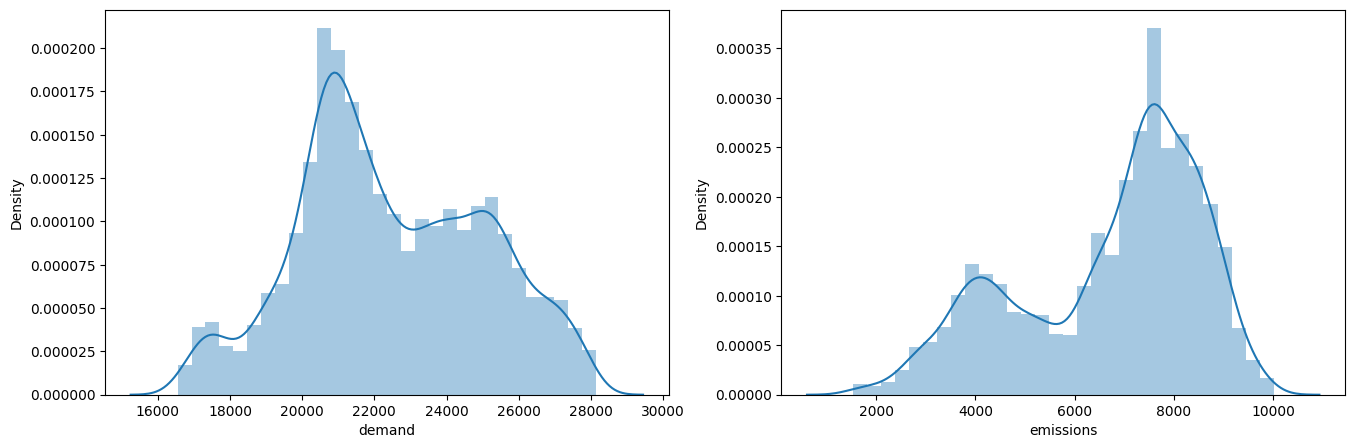

In [11]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['demand'])
plt.subplot(1,2,2)
sns.distplot(df['emissions'])
plt.show()

**Correlation heatmap**

<AxesSubplot: >

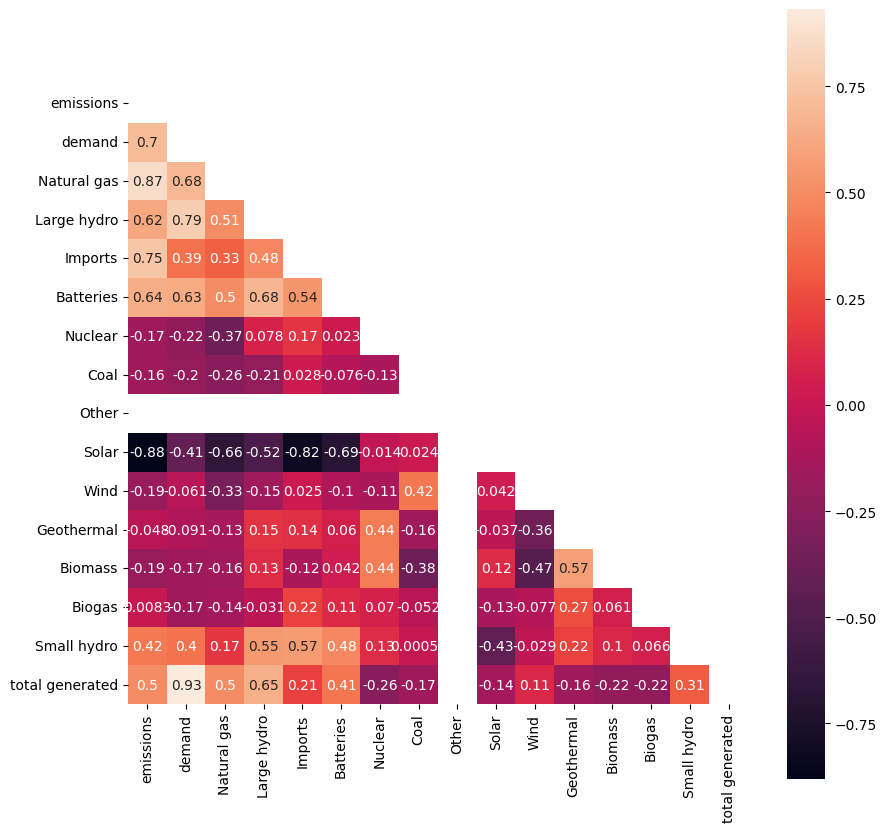

In [12]:
df = df.drop(columns=['date'])
correlation = df.corr(method = 'pearson')
plt.subplots(figsize = (10,10))
masked = np.triu(np.ones_like(correlation, dtype=bool)) 
sns.heatmap(correlation,mask=masked,square = True, annot = True)

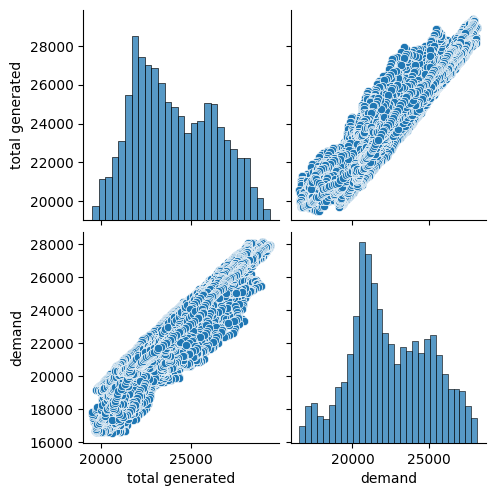

Correlation coefficient: 0.9316635281360498
p-value: 0.0


In [14]:
# Relation between total energy generated and the amount of energy demanded at any given moment

ed = df[['total generated','demand']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['total generated'], df['demand'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['total generated'], df['demand']).pvalue
print(f'p-value: {p_value}')

Highly correlated. I imagine that CAISO's 5-minute increment predictions must be very good

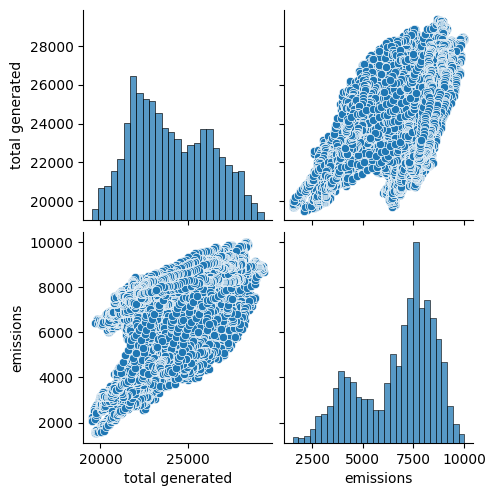

Correlation coefficient: 0.49535192905713465
p-value: 0.0


In [15]:
# Relation between total energy generated and emissions at any given moment

ed = df[['total generated','emissions']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['total generated'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['total generated'], df['emissions']).pvalue
print(f'p-value: {p_value}')

Mild positive correlation between total generated energy and emissions. The total is likely not enough to accurately predict emissions--we need the breakdown by resources

**Emissions/demand direction correlation**

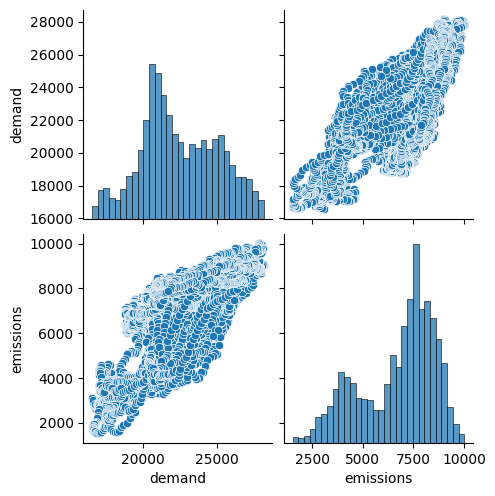

Correlation coefficient: 0.7047958702325611
p-value: 0.0


In [20]:
ed = df[['demand','emissions']]

sns.pairplot(ed, kind='scatter')
plt.show()

corrcoef = np.corrcoef(df['demand'], df['emissions'])[0,1]
print(f'Correlation coefficient: {corrcoef}')

p_value = linregress(df['demand'], df['emissions']).pvalue
print(f'p-value: {p_value}')

Mildly strong positive correlation

In [21]:
X = df[['demand']]
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

print(f'Input: {list(X.columns)}')
print(f'Training data score: {linear_reg.score(X_train,  y_train)}')
print(f'Testing data score: {linear_reg.score(X_test, y_test)}')

Input: ['demand']
Training data score: 0.491986855908388
Testing data score: 0.5148697821085557


But poor performance for linear regression. I suspect that demand alone is not enough to accurately predict demand

**Emissions estimation**

In [22]:
# Random forest regressor

# Sanity check: energy generation by resource is used to calculate CO2 emissions, so model should be at nearly 100% accuracy with energy generation as only input and emissions as output

X = df.drop(columns=['emissions','time','demand']) # only input energy generation values
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

distribution = {
        'n_estimators': [2,3,5,10,20,50,100,200],  
        'max_features': ['sqrt','log2','auto'],
       }

random_forest = RandomForestRegressor()
rscv = RandomizedSearchCV(estimator = random_forest, param_distributions = distribution, n_iter = 10)                
rscv.fit(X_train,  y_train)

print(f'Best parameters: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Best parameters: {'n_estimators': 200, 'max_features': 'auto'}
Training data score: 0.9996035795191189
Testing data score: 0.9973038749466344


In [23]:
# Support vector

# Same as above

X = df.drop(columns=['emissions','time','demand']) # only input energy generation values
y = df['emissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

distribution = {
        'epsilon': [0.1,0.5,1,2,3],
        'C': [0.1,0.5,1,5,10,20]
       }

svr = SVR()
rscv = RandomizedSearchCV(estimator = svr, param_distributions = distribution, n_iter = 10)                
rscv.fit(X_train,  y_train)

print(f'Best parameters: {rscv.best_params_}')
print(f'Training data score: {rscv.score(X_train,  y_train)}')
print(f'Testing data score: {rscv.score(X_test, y_test)}')


Best parameters: {'epsilon': 0.5, 'C': 20}
Training data score: 0.9825230055858272
Testing data score: 0.9825186050850468


**Conclusion**

If demand isn't enough, what features might be useful for predicting emissions? In the following analyses, we will introduce data on weather and vehicle distribution. N.B. due to the other datasets not being available at as high a resolution as these 5-minute increment emissions, demand, and supply datasets, we will switch to a monthly scale in the following notebooks